# GroupBy

**Outcomes**

- Understand the split-apply-combine strategy for aggregate
  computations on groups of data  
- Be able use basic aggregation methods on `df.groupby` to compute
  within group statistics  
- Understand how to group by multiple keys at once  


**Data**

- Details for all delayed US domestic flights in December 2016,
  obtained from the [Bureau of Transportation
  Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time)  

In [1]:
import random
import numpy as np
import pandas as pd
import qeds
import matplotlib.pyplot as plt

%matplotlib inline

# activate plot theme
qeds.themes.mpl_style();

## Split-Apply-Combine

One powerful paradigm for analyzing data is the “Split-Apply-Combine”
strategy.

This strategy has three steps:

1. `Split`: split the data into groups based on values in one or more columns.  
1. `Apply`: apply a function or routine to each group separately.  
1. `Combine`: combine the output of the apply step into a DataFrame,
  using the group identifiers as the index.  


We will cover the main components in this lecture, but we encourage you
to also study the [official
documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html)
to learn more about what is possible.

To describe the concepts, we will need some data.

We will begin with a simple made-up dataset to discuss the concepts and
then work through extended example and exercises with real data.

In [2]:
C = np.arange(1, 7, dtype=float)
C[[3, 5]] = np.nan
df = pd.DataFrame({
    "A" : [1, 1, 1, 2, 2, 2],
    "B" : [1, 1, 2, 2, 1, 1],
    "C": C,
})
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


### Simple Example

To perform the *Split* step, we call the `groupby` method on our
DataFrame.

The first argument to `groupby` is a description of how we want to
construct groups.

In the most basic version, we will pass a string identifying the column
name.

In [3]:
gbA = df.groupby("A")

The `type` of variable we get back is a `DataFrameGroupBy`, which we
will sometimes refer to as GroupBy for short.

In [4]:
type(gbA)

pandas.core.groupby.generic.DataFrameGroupBy

Looking at the “groups” inside of the GroupBy object can help us
understand what the GroupBy represents.

We can do this with the `gb.get_group(group_name)` method.

In [5]:
gbA.get_group(1)

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0


In [6]:
gbA.get_group(2)

,A,B,C
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


We can *apply* some of our favorite aggregation functions directly on the
`GroupBy` object.

**Exercise 1**

Look closely at the output of the cells below.

How did pandas compute the sum of `gbA`? What happened to the `NaN`
entries in column `C`?

Write your thoughts.

Hint: try `gbA.count()` or `gbA.mean()` if you can't decide what
happened to the `NaN`.

In [7]:
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


In [8]:
gbA.sum()

,B,C
A,,
1,4,6.0
2,4,5.0


**Exercise 2**

Use introspection (tab completion) to see what other aggregations are
defined for GroupBy objects.

Pick three and evaluate them in the cells below.

Does the output of each of these commands have the same features as the
output of `gbA.sum()` from above? If not, what is different?

In [9]:
gbA.agg(len)

,B,C
A,,
1,3,3.0
2,3,3.0


In [10]:
gbA.max()

,B,C
A,,
1,2,3.0
2,2,5.0


In [11]:
gbA.median()

,B,C
A,,
1,1,2.0
2,1,5.0


If we pass a list of strings to `groupby`, it will group based on
unique combinations of values from all columns in the list.

Let’s see an example.

In [12]:
gbAB = df.groupby(["A", "B"])
type(gbAB)

pandas.core.groupby.generic.DataFrameGroupBy

In [13]:
gbAB.get_group((1, 1))

,A,B,C
0,1,1,1.0
1,1,1,2.0


Notice that we still have a GroupBy object, so we can apply our favorite
aggregations.

In [15]:
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


In [14]:
gbAB.count()

C
A B   
1 1  2
  2  1
2 1  1
  2  0

Notice that the output is a DataFrame with two levels on the index
and a single column `C`. (Quiz: how do we know it is a DataFrame with
one column and not a Series?)

This highlights a principle of how pandas handles the *Combine* part of
the strategy:

> The index of the combined DataFrame will be the group identifiers,
with one index level per group key.

### Custom Aggregate Functions

So far, we have been applying built-in aggregations to our GroupBy object.

We can also apply custom aggregations to each group of a GroupBy in two
steps:

1. Write our custom aggregation as a Python function.  
1. Passing our function as an argument to the `.agg` method of a GroupBy.  


Let’s see an example.

In [16]:
def num_missing(df):
    "Return the number of missing items in each column of df"
    return df.isnull().sum()

We can call this function on our original DataFrame to get the number of
missing items in each column.

In [17]:
num_missing(df)

A    0
B    0
C    2
dtype: int64

We can also apply it to a GroupBy object to get the number of missing
items in each column *for each group*.

In [18]:
gbA.agg(num_missing)

,B,C
A,,
1,0,0.0
2,0,2.0


The key to keep in mind is that the function we pass to `agg` should
take in a DataFrame (or Series) and return a Series (or single value)
with one item per column in the original DataFrame.

When the function is called, the data for each group will be passed to
our function as a DataFrame (or Series).

### Transforms: The `apply` Method

As we saw in the [basics lecture](https://quantecon.github.io/2021-workshop-rsit/week1/session4/pandas-basics.html), we can apply transforms to DataFrames.

We can do the same with GroupBy objects using the `.apply` method.

Let’s see an example.

In [19]:
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


In [24]:
def smallest_by_b(df):
    return df.nsmallest(2, "B").reset_index(drop=True)

In [25]:
gbA.apply(smallest_by_b)

B    C
A          
1 0  1  1.0
  1  1  2.0
2 0  1  5.0
  1  1  NaN

Notice that the return value from applying our series transform to `gbA`
was the group key on the outer level (the `A` column) and the original
index from `df` on the inner level.

The original index came along because that was the index of the
DataFrame returned by `smallest_by_b`.

Had our function returned something other than the index from `df`,
that would appear in the result of the call to `.apply`.


**Exercise 3**

> This exercise has a few steps:

1. Write a function that, given a DataFrame, computes each entry's
deviation from the mean of its column.
2. Apply the function to `gbA`.
3. With your neighbor describe what the index and and columns are? Where
are the group keys (the `A` column)?
4. Determine the correct way to add these results back into `df` as
new columns. (Hint: remember the merge lecture)

In [26]:
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


In [ ]:
gbA = df.groupby("A")

In [29]:
df

,A,B,C
0,1,1,1.0
1,1,1,2.0
2,1,2,3.0
3,2,2,NaN
4,2,1,5.0
5,2,1,NaN


In [28]:
deviation_from_mean(df)

,A,B,C
0,-0.5,-0.333333,-1.75
1,-0.5,-0.333333,-0.75
2,-0.5,0.666667,0.25
3,0.5,0.666667,NaN
4,0.5,-0.333333,2.25
5,0.5,-0.333333,NaN


In [34]:
df.mean(axis="index")  # df.mean(axis=0)

A    1.500000
B    1.333333
C    2.750000
dtype: float64

In [35]:
df.mean()

A    1.500000
B    1.333333
C    2.750000
dtype: float64

In [36]:
df.mean(axis="columns")  # df.mean(axis=1)

0    1.000000
1    1.333333
2    2.000000
3    2.000000
4    2.666667
5    1.500000
dtype: float64

In [31]:
# write function here
def deviation_from_mean(df):
    return df - df.mean(axis="index")

# apply function here
devs = gbA.apply(deviation_from_mean)

In [32]:
# Add the columns back to df
df.merge(devs, left_index=True, right_index=True, suffixes=["", "_dev"])

,A,B,C,B_dev,C_dev
0,1,1,1.0,-0.333333,-1.0
1,1,1,2.0,-0.333333,0.0
2,1,2,3.0,0.666667,1.0
3,2,2,NaN,0.666667,NaN
4,2,1,5.0,-0.333333,0.0
5,2,1,NaN,-0.333333,NaN


### `pd.Grouper`

Sometimes, in order to construct the groups you want, you need to give
pandas more information than just a column name.

Some examples are:

- Grouping by a column and a level of the index.  
- Grouping time series data at a particular frequency.  


pandas lets you do this through the `pd.Grouper` type.

To see it in action, let’s make a copy of `df` with `A` moved to the
index and a `Date` column added.

In [37]:
df2 = df.copy()
df2["Date"] = pd.date_range(
    start=pd.datetime.today().strftime("%m/%d/%Y"),
    freq="BQ",
    periods=df.shape[0]
)
df2 = df2.set_index("A")
df2

<ipython-input-37-66f059155868>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start=pd.datetime.today().strftime("%m/%d/%Y"),


,B,C,Date
A,,,
1,1,1.0,2021-03-31
1,1,2.0,2021-06-30
1,2,3.0,2021-09-30
2,2,NaN,2021-12-31
2,1,5.0,2022-03-31
2,1,NaN,2022-06-30


In [41]:
df2.groupby("A").mean()

,B,C
A,,
1,1.333333,2.0
2,1.333333,5.0


In [ ]:
# df2.groupby(pd.Grouper(level="A"))

In [38]:
df2.groupby("Date").mean()

,B,C
Date,,
2021-03-31,1,1.0
2021-06-30,1,2.0
2021-09-30,2,3.0
2021-12-31,2,NaN
2022-03-31,1,5.0
2022-06-30,1,NaN


We can group by year.

In [39]:
df2.groupby(pd.Grouper(key="Date", freq="A")).count()

,B,C
Date,,
2021-12-31,4,3
2022-12-31,2,1


We can group by the `A` level of the index.

In [42]:
df2.groupby(pd.Grouper(level="A")).count()

,B,C,Date
A,,,
1,3,3,3
2,3,1,3


We can combine these to group by both.

In [43]:
df2.groupby([pd.Grouper(key="Date", freq="A"), pd.Grouper(level="A")]).count()

B  C
Date       A      
2021-12-31 1  3  3
           2  1  0
2022-12-31 2  2  1

And we can combine `pd.Grouper` with a string, where the string
denotes a column name

In [44]:
df2.groupby([pd.Grouper(key="Date", freq="A"), "B"]).count()

C
Date       B   
2021-12-31 1  2
           2  1
2022-12-31 1  1

## Case Study: Airline Delays

Let’s apply our new split-apply-combine skills to the airline dataset we
saw in the [merge](merge.ipynb) lecture.

In [47]:
air_dec.columns

Index(['Carrier', 'TailNum', 'FlightNum', 'OriginCityMarketID', 'Origin',
       'OriginCityName', 'OriginStateName', 'DestCityMarketID', 'Dest',
       'DestCityName', 'DestStateName', 'CRSDepTime', 'DepTime', 'DepDelay',
       'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime',
       'ArrDelay', 'Cancelled', 'CancellationCode', 'Diverted',
       'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'Distance',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'FirstDepTime', 'TotalAddGTime', 'Date'],
      dtype='object')

In [45]:
air_dec = qeds.load("airline_performance_dec16")

First, we compute the average delay in arrival time for all carriers
each week.

In [52]:
air_dec.head()["Date"]

0   2016-12-18
1   2016-12-19
2   2016-12-20
3   2016-12-21
4   2016-12-22
Name: Date, dtype: datetime64[ns]

In [50]:
air_dec.groupby(["Date", "Carrier"])["ArrDelay"].mean().unstack()

Carrier,AA,AS,B6,DL,EV,F9,HA,NK,OO,UA,VX,WN
Date,,,,,,,,,,,,
2016-12-01,-3.249176,-0.917031,0.690088,-6.474708,1.034981,-2.945833,3.425743,-0.466837,-3.697689,-2.092489,-5.291262,-4.885057
2016-12-02,-4.401472,4.112583,-4.939317,-6.856143,1.886311,-4.697674,-4.591549,8.138191,3.343396,-1.082552,2.458937,-1.682405
2016-12-03,-6.450842,-0.306075,-5.286558,-8.401674,11.802938,-5.083665,1.285714,0.226463,-4.249383,-2.641051,-4.206667,-6.125619
2016-12-04,6.531223,7.926503,-2.400778,0.713982,23.330616,1.166008,-2.063725,13.928753,15.098757,27.537439,-2.027174,5.420748
2016-12-05,-0.672994,47.352381,11.762516,3.444357,27.411765,6.649805,-0.576355,9.552699,17.949045,6.526848,9.158416,1.874448
2016-12-06,-1.037753,-5.155941,5.456164,-0.234008,9.605983,-2.503937,-2.619289,9.963351,5.918582,-0.746914,-8.235000,-1.636464
2016-12-07,-2.322567,4.311111,1.810959,-5.916833,6.763844,1.140152,6.722772,-2.743523,10.090385,3.170635,3.065657,-1.187809
2016-12-08,3.978548,3.163366,2.695431,0.240950,16.826531,6.030303,-0.049020,9.640306,20.210997,5.010585,26.880597,4.794724
2016-12-09,1.298569,27.325581,6.909887,0.628016,12.543307,9.257463,2.098131,8.959596,17.954198,4.426342,27.352941,1.649427


In [55]:
pd.Grouper?

In [58]:
weekly_delays = (
    air_dec
    .groupby([pd.Grouper(key="Date", freq="W"), "Carrier"])
    ["ArrDelay"]               # extract one column
    .mean()                    # take average
    .unstack(level="Carrier")  # Flip carrier up as column names
)
weekly_delays

Carrier,AA,AS,B6,DL,EV,F9,HA,NK,OO,UA,VX,WN
Date,,,,,,,,,,,,
2016-12-04,-1.714887,2.724273,-2.894269,-5.088351,8.655332,-2.894212,-0.558282,5.468909,2.749573,5.564496,-2.121821,-1.663695
2016-12-11,1.148833,12.052031,5.795062,2.507745,13.220673,4.578861,2.054302,8.713755,15.429660,4.094176,12.080938,1.865933
2016-12-18,16.357561,7.643767,34.608356,18.000000,23.876622,45.014888,9.388889,22.857899,30.901639,22.398130,33.651128,18.373400
2016-12-25,6.364513,2.719699,5.586836,-0.916113,6.857143,54.084959,5.075747,10.443369,15.004780,5.332474,17.286917,10.197685
2017-01-01,2.321836,1.226662,10.661577,2.048116,6.800898,8.280298,6.970016,8.361123,8.971083,0.061786,1.349580,5.213019


Let’s also plot this data.

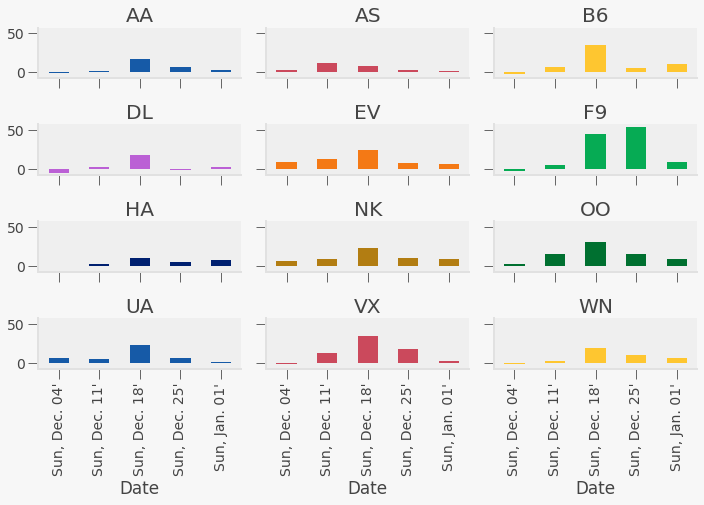

In [59]:
# plot
axs = weekly_delays.plot.bar(
    figsize=(10, 8), subplots=True, legend=False, sharex=True,
    sharey=True, layout=(4, 3), grid=False
)

# tweak spacing between subplots and xaxis labels
axs[0,0].get_figure().tight_layout()
for ax in axs[-1, :]:
    ax.set_xticklabels(weekly_delays.index.strftime("%a, %b. %d'"))

It looks like more delays occurred during the week ending Sunday
December 18th than any other week (except for Frontier, who did *worse*
on Christmas week).

Let’s see why.

The `air_dec` DataFrame has information on the minutes of delay
attributed to 5 different categories:

In [60]:
delay_cols = [
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

Let’s take a quick look at each of those delay categories for the week ending December 18, 2016.

In [62]:
pre_christmas = air_dec.loc[
    (air_dec["Date"] >= "2016-12-12") & (air_dec["Date"] <= "2016-12-18")
]

In [63]:
pre_christmas

,Carrier,TailNum,FlightNum,OriginCityMarketID,Origin,OriginCityName,OriginStateName,DestCityMarketID,Dest,DestCityName,...,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,Date
0,AA,N3JHAA,46,31650,MSP,"Minneapolis, MN",Minnesota,30977,ORD,"Chicago, IL",...,58.0,334.0,0.0,0.0,20.0,0.0,0.0,NaN,NaN,2016-12-18
24,AA,N424AA,50,31123,STL,"St. Louis, MO",Missouri,30194,DFW,"Dallas/Fort Worth, TX",...,90.0,550.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2016-12-12
25,AA,N4XFAA,50,31123,STL,"St. Louis, MO",Missouri,30194,DFW,"Dallas/Fort Worth, TX",...,90.0,550.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2016-12-13
26,AA,N4XDAA,50,31123,STL,"St. Louis, MO",Missouri,30194,DFW,"Dallas/Fort Worth, TX",...,87.0,550.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2016-12-14
27,AA,N4XYAA,50,31123,STL,"St. Louis, MO",Missouri,30194,DFW,"Dallas/Fort Worth, TX",...,84.0,550.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2016-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459633,NK,N531NK,126,32467,FLL,"Fort Lauderdale, FL",Florida,31135,MYR,"Myrtle Beach, SC",...,80.0,529.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2016-12-14
459634,NK,N519NK,126,32467,FLL,"Fort Lauderdale, FL",Florida,31135,MYR,"Myrtle Beach, SC",...,79.0,529.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2016-12-15
459635,NK,N522NK,126,32467,FLL,"Fort Lauderdale, FL",Florida,31135,MYR,"Myrtle Beach, SC",...,75.0,529.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2016-12-16
459636,NK,N505NK,126,32467,FLL,"Fort Lauderdale, FL",Florida,31135,MYR,"Myrtle Beach, SC",...,80.0,529.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2016-12-17


In [64]:
# custom agg function
def positive(df):
    return (df > 0).sum()

delay_totals = pre_christmas.groupby("Carrier")[delay_cols].agg(["sum", "mean", positive])

delay_totals

CarrierDelay                     WeatherDelay                     \
                 sum       mean positive          sum      mean positive   
Carrier                                                                    
AA          105732.0   6.258553   2922.0      21820.0  1.291583    456.0   
AS            8762.0   2.691032    250.0       3219.0  0.988636     61.0   
B6           49421.0   9.031615   1575.0       9894.0  1.808114    112.0   
DL          151188.0   8.864212   2878.0      39145.0  2.295087    783.0   
EV           87408.0   9.939504   1375.0       3824.0  0.434842     76.0   
F9           19568.0  10.430704    361.0       6198.0  3.303838     57.0   
HA            7199.0   5.034266    218.0       3650.0  2.552448    145.0   
NK           14735.0   5.294646    452.0       2240.0  0.804887     56.0   
OO          120307.0  10.439691   1378.0      26349.0  2.286446    308.0   
UA           66693.0   6.312636   1851.0      31602.0  2.991197    521.0   
VX            8048.0   5.608362    246.0       3807.0  2.652962    126.0   
WN          123882.0   4.873790   5393.0      23516.0  0.925171    328.0   

        NASDelay                     SecurityDelay                     \
             sum       mean positive           sum      mean positive   
Carrier                                                                 
AA       77279.0   4.574346   3159.0         721.0  0.042678     35.0   
AS       16344.0   5.019656    614.0         163.0  0.050061     10.0   
B6       38741.0   7.079861   1326.0         672.0  0.122807     30.0   
DL       75110.0   4.403729   2605.0         107.0  0.006273      2.0   
EV       49703.0   5.651922   1580.0           0.0  0.000000      0.0   
F9       22459.0  11.971748    493.0           0.0  0.000000      0.0   
HA          86.0   0.060140      4.0          35.0  0.024476      3.0   
NK       30361.0  10.909450    840.0          50.0  0.017966      5.0   
OO       54141.0   4.698108   2289.0         171.0  0.014839     12.0   
UA       74992.0   7.098154   2065.0           0.0  0.000000      0.0   
VX       12619.0   8.793728    224.0          73.0  0.050871      4.0   
WN       78645.0   3.094067   4247.0         252.0  0.009914     18.0   

        LateAircraftDelay                      
                      sum       mean positive  
Carrier                                        
AA               141249.0   8.360897   2574.0  
AS                13599.0   4.176597    271.0  
B6               100811.0  18.423063   1433.0  
DL               122896.0   7.205441   2289.0  
EV                89773.0  10.208438   1568.0  
F9                32236.0  17.183369    316.0  
HA                 4024.0   2.813986    189.0  
NK                22247.0   7.993891    372.0  
OO               166102.0  14.413572   2459.0  
UA               118728.0  11.237861   1696.0  
VX                25242.0  17.590244    331.0  
WN               285073.0  11.215399   6472.0

**Want**: plot total, average, and number of each type of delay by
carrier

To do this, we need to have a DataFrame with:

- Delay type in index (so it is on horizontal-axis)  
- Aggregation method on *outer* most level of columns (so we can do
  `data["mean"]` to get averages)  
- Carrier name on inner level of columns  


Many sequences of the reshaping commands can accomplish this.

We show one example below.

In [69]:
delay_totals.swaplevel?

In [71]:
delay_totals.stack().T.swaplevel(axis=1)

,sum,mean,positive,sum,mean,positive,sum,mean,positive,sum,...,positive,sum,mean,positive,sum,mean,positive,sum,mean,positive
Carrier,AA,AA,AA,AS,AS,AS,B6,B6,B6,DL,...,OO,UA,UA,UA,VX,VX,VX,WN,WN,WN
CarrierDelay,105732.0,6.258553,2922.0,8762.0,2.691032,250.0,49421.0,9.031615,1575.0,151188.0,...,1378.0,66693.0,6.312636,1851.0,8048.0,5.608362,246.0,123882.0,4.873790,5393.0
WeatherDelay,21820.0,1.291583,456.0,3219.0,0.988636,61.0,9894.0,1.808114,112.0,39145.0,...,308.0,31602.0,2.991197,521.0,3807.0,2.652962,126.0,23516.0,0.925171,328.0
NASDelay,77279.0,4.574346,3159.0,16344.0,5.019656,614.0,38741.0,7.079861,1326.0,75110.0,...,2289.0,74992.0,7.098154,2065.0,12619.0,8.793728,224.0,78645.0,3.094067,4247.0
SecurityDelay,721.0,0.042678,35.0,163.0,0.050061,10.0,672.0,0.122807,30.0,107.0,...,12.0,0.0,0.000000,0.0,73.0,0.050871,4.0,252.0,0.009914,18.0
LateAircraftDelay,141249.0,8.360897,2574.0,13599.0,4.176597,271.0,100811.0,18.423063,1433.0,122896.0,...,2459.0,118728.0,11.237861,1696.0,25242.0,17.590244,331.0,285073.0,11.215399,6472.0


In [70]:
delay_totals.stack().T

Carrier                  AA                          AS                     \
                        sum      mean positive      sum      mean positive   
CarrierDelay       105732.0  6.258553   2922.0   8762.0  2.691032    250.0   
WeatherDelay        21820.0  1.291583    456.0   3219.0  0.988636     61.0   
NASDelay            77279.0  4.574346   3159.0  16344.0  5.019656    614.0   
SecurityDelay         721.0  0.042678     35.0    163.0  0.050061     10.0   
LateAircraftDelay  141249.0  8.360897   2574.0  13599.0  4.176597    271.0   

Carrier                  B6                            DL  ...       OO  \
                        sum       mean positive       sum  ... positive   
CarrierDelay        49421.0   9.031615   1575.0  151188.0  ...   1378.0   
WeatherDelay         9894.0   1.808114    112.0   39145.0  ...    308.0   
NASDelay            38741.0   7.079861   1326.0   75110.0  ...   2289.0   
SecurityDelay         672.0   0.122807     30.0     107.0  ...     12.0   
LateAircraftDelay  100811.0  18.423063   1433.0  122896.0  ...   2459.0   

Carrier                  UA                           VX                      \
                        sum       mean positive      sum       mean positive   
CarrierDelay        66693.0   6.312636   1851.0   8048.0   5.608362    246.0   
WeatherDelay        31602.0   2.991197    521.0   3807.0   2.652962    126.0   
NASDelay            74992.0   7.098154   2065.0  12619.0   8.793728    224.0   
SecurityDelay           0.0   0.000000      0.0     73.0   0.050871      4.0   
LateAircraftDelay  118728.0  11.237861   1696.0  25242.0  17.590244    331.0   

Carrier                  WN                      
                        sum       mean positive  
CarrierDelay       123882.0   4.873790   5393.0  
WeatherDelay        23516.0   0.925171    328.0  
NASDelay            78645.0   3.094067   4247.0  
SecurityDelay         252.0   0.009914     18.0  
LateAircraftDelay  285073.0  11.215399   6472.0  

[5 rows x 36 columns]

In [65]:
reshaped_delays = (
    delay_totals
    .stack()             # move aggregation method into index (with Carrier)
    .T                   # put delay type in index and Carrier+agg in column
    .swaplevel(axis=1)   # make agg method outer level of column label
    .sort_index(axis=1)  # sort column labels so it prints nicely
)
reshaped_delays

mean                                            \
Carrier                  AA        AS         B6        DL         EV   
CarrierDelay       6.258553  2.691032   9.031615  8.864212   9.939504   
WeatherDelay       1.291583  0.988636   1.808114  2.295087   0.434842   
NASDelay           4.574346  5.019656   7.079861  4.403729   5.651922   
SecurityDelay      0.042678  0.050061   0.122807  0.006273   0.000000   
LateAircraftDelay  8.360897  4.176597  18.423063  7.205441  10.208438   

                                                                         ...  \
Carrier                   F9        HA         NK         OO         UA  ...   
CarrierDelay       10.430704  5.034266   5.294646  10.439691   6.312636  ...   
WeatherDelay        3.303838  2.552448   0.804887   2.286446   2.991197  ...   
NASDelay           11.971748  0.060140  10.909450   4.698108   7.098154  ...   
SecurityDelay       0.000000  0.024476   0.017966   0.014839   0.000000  ...   
LateAircraftDelay  17.183369  2.813986   7.993891  14.413572  11.237861  ...   

                        sum                                               \
Carrier                  B6        DL       EV       F9      HA       NK   
CarrierDelay        49421.0  151188.0  87408.0  19568.0  7199.0  14735.0   
WeatherDelay         9894.0   39145.0   3824.0   6198.0  3650.0   2240.0   
NASDelay            38741.0   75110.0  49703.0  22459.0    86.0  30361.0   
SecurityDelay         672.0     107.0      0.0      0.0    35.0     50.0   
LateAircraftDelay  100811.0  122896.0  89773.0  32236.0  4024.0  22247.0   

                                                          
Carrier                  OO        UA       VX        WN  
CarrierDelay       120307.0   66693.0   8048.0  123882.0  
WeatherDelay        26349.0   31602.0   3807.0   23516.0  
NASDelay            54141.0   74992.0  12619.0   78645.0  
SecurityDelay         171.0       0.0     73.0     252.0  
LateAircraftDelay  166102.0  118728.0  25242.0  285073.0  

[5 rows x 36 columns]

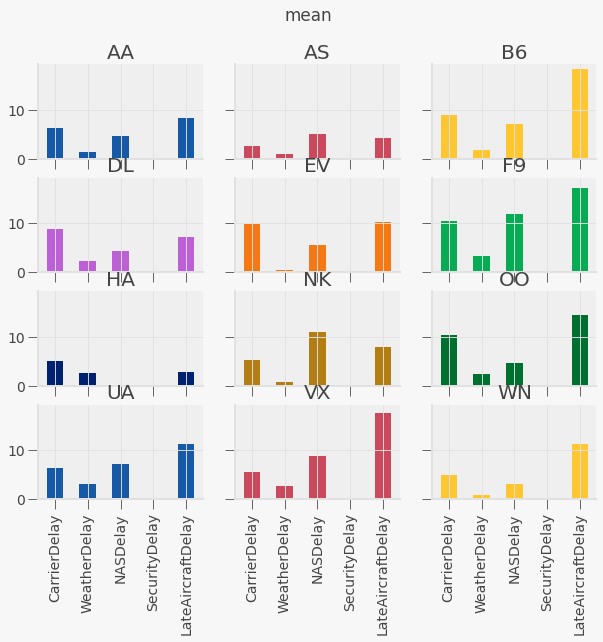

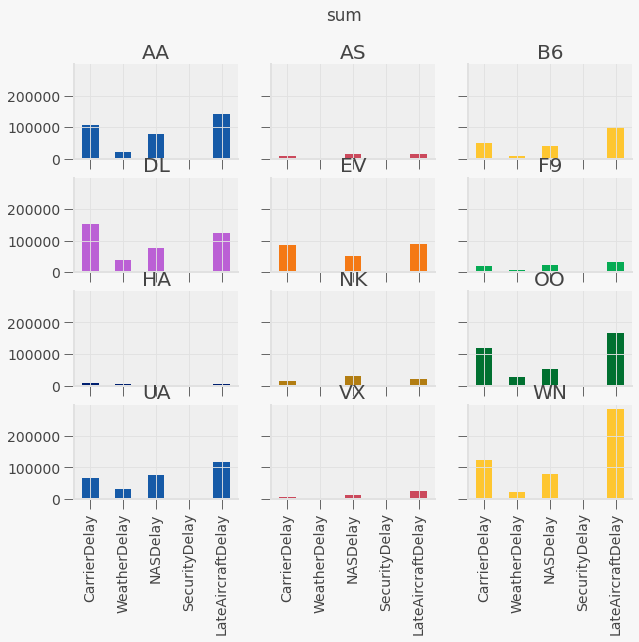

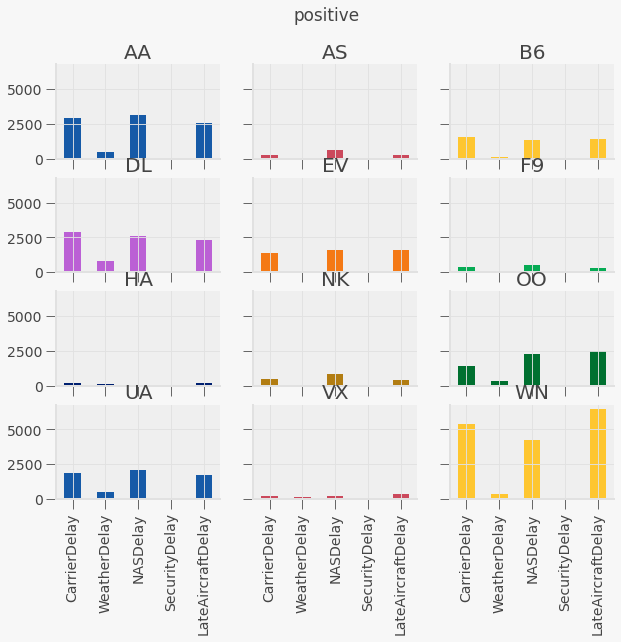

In [72]:
for agg in ["mean", "sum", "positive"]:
    axs = reshaped_delays[agg].plot(
        kind="bar", subplots=True, layout=(4, 3), figsize=(10, 8), legend=False,
        sharex=True, sharey=True
    )
    fig = axs[0, 0].get_figure()
    fig.suptitle(agg)
#     fig.tight_layout();

- Which type of delay was the most common?  
- Which one caused the largest average delay?  
- Does that vary by airline?

Let’s summarize what we did:

- Computed average flight delay for each airline for each week.  
- Noticed that one week had more delays for all airlines.  
- Studied the flights in that week to determine the *cause* of the
  delays in that week.  


Suppose now that we want to repeat that analysis, but at a daily
frequency instead of weekly.

We could copy/paste the code from above and change the `W` to a `D`,
but there’s a better way…

Let’s convert the steps above into two functions:

1. Produce the set of bar charts for average delays at each frequency.  
1. Produce the second set of charts for the total, average, and number
  of occurrences of each type of delay.  

In [73]:
def mean_delay_plot(df, freq, figsize=(10, 8)):
    """
    Make a bar chart of average flight delays for each carrier at
    a given frequency.
    """
    mean_delays = (
        df
        .groupby([pd.Grouper(key="Date", freq=freq), "Carrier"])
        ["ArrDelay"]               # extract one column
        .mean()                    # take average
        .unstack(level="Carrier")  # Flip carrier up as column names
    )

    # plot
    axs = mean_delays.plot.bar(
        figsize=figsize, subplots=True, legend=False, sharex=True,
        sharey=True, layout=(4, 3), grid=False
    )

    # tweak spacing between subplots and x-axis labels
    axs[0, 0].get_figure().tight_layout()
    for ax in axs[-1, :]:
        ax.set_xticklabels(mean_delays.index.strftime("%a, %b. %d'"))

    # return the axes in case we want to further tweak the plot outside the function
    return axs


def delay_type_plot(df, start, end):
    """
    Make bar charts for total minutes, average minutes, and number of
    occurrences for each delay type, for all flights that were scheduled
    between `start` date and `end` date
    """
    sub_df = df.loc[
        (df["Date"] >= start) & (df["Date"] <= end)
    ]

    def positive(df):
        return (df > 0).sum() / df.shape[0]

    aggs = sub_df.groupby("Carrier")[delay_cols].agg(["sum", "mean", positive])

    reshaped = aggs.stack().T.swaplevel(axis=1).sort_index(axis=1)

    for agg in ["mean", "sum", "positive"]:
        axs = reshaped[agg].plot(
            kind="bar", subplots=True, layout=(4, 3), figsize=(10, 8), legend=False,
            sharex=True, sharey=True
        )
        fig = axs[0, 0].get_figure()
        fig.suptitle(agg)
#         fig.tight_layout();

Now let’s look at that plot at a daily frequency. (Note that we need the
figure to be a bit wider in order to see the dates.)

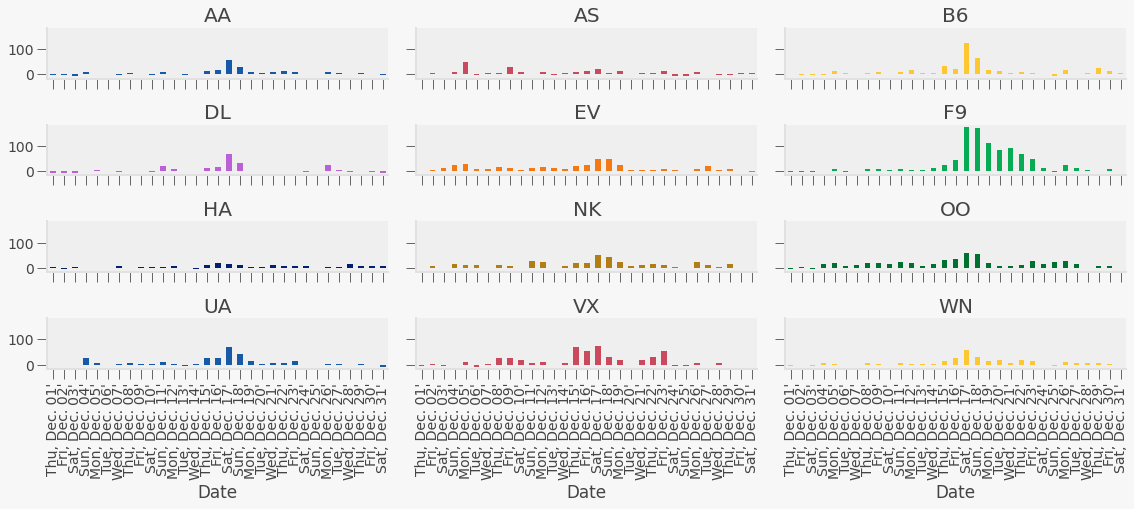

In [76]:
mean_delay_plot(air_dec, "D", figsize=(16, 8));

As we expected given our analysis above, the longest average delays
seemed to happen in the third week.

In particular, it looks like December 17th and 18th had — on average —
higher delays than other days in December.

Let’s use the `delay_type_plot` function to determine the cause of the
delays on those two days.

Because our analysis is captured in a single function, we can look at
the days together and separately without much effort.

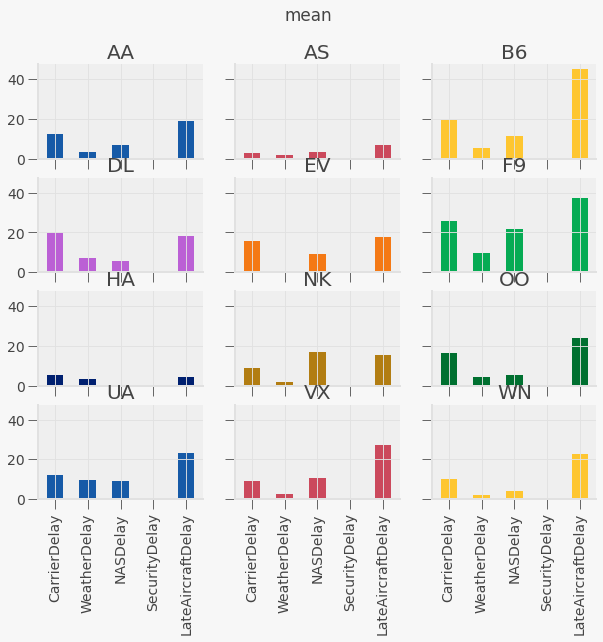

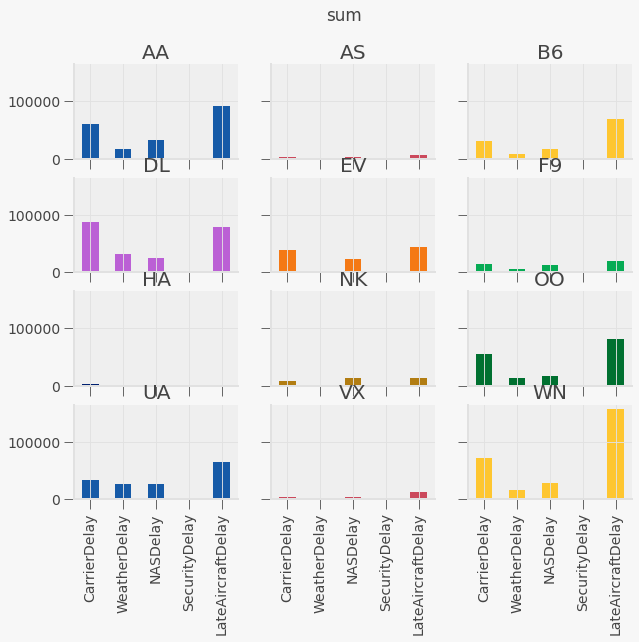

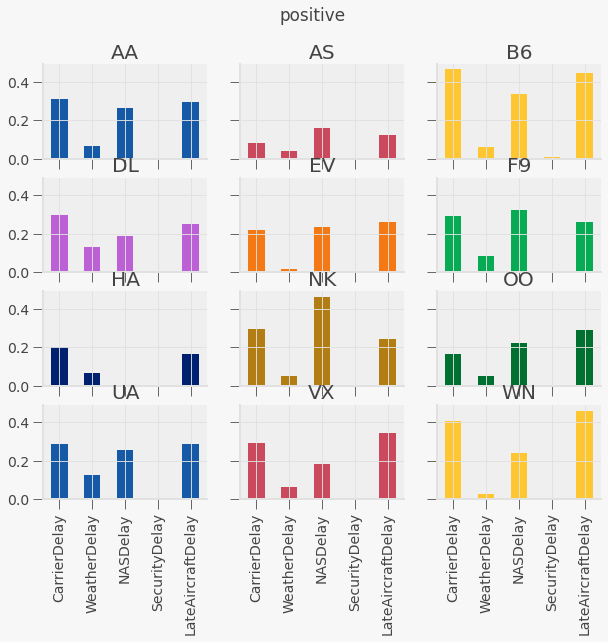

In [77]:
# both days
delay_type_plot(air_dec, "12-17-16", "12-18-16")

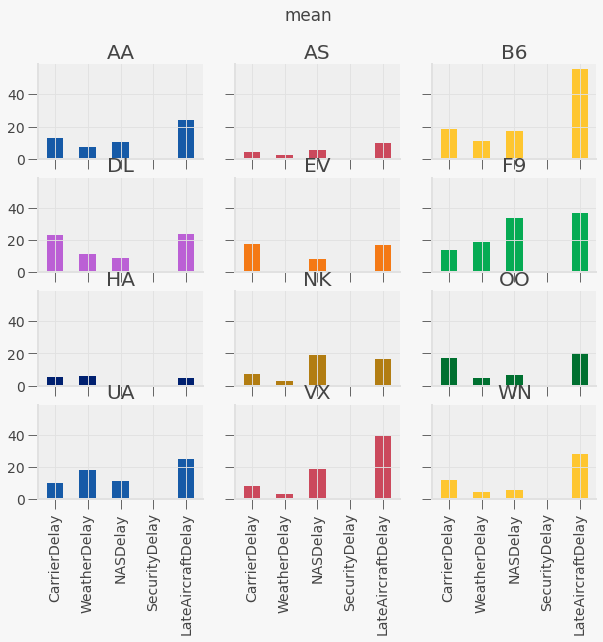

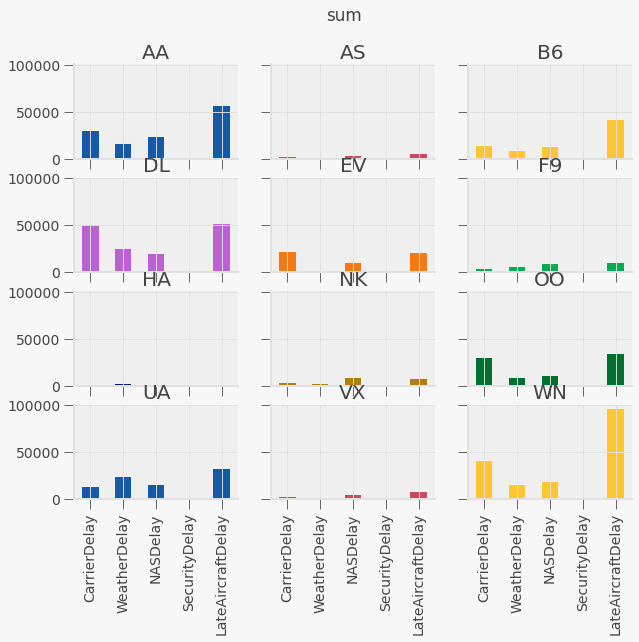

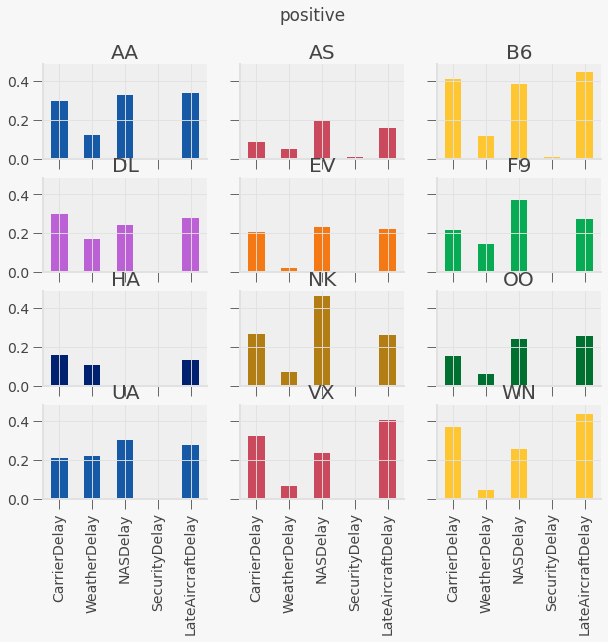

In [78]:
# only the 17th
delay_type_plot(air_dec, "12-17-16", "12-17-16")

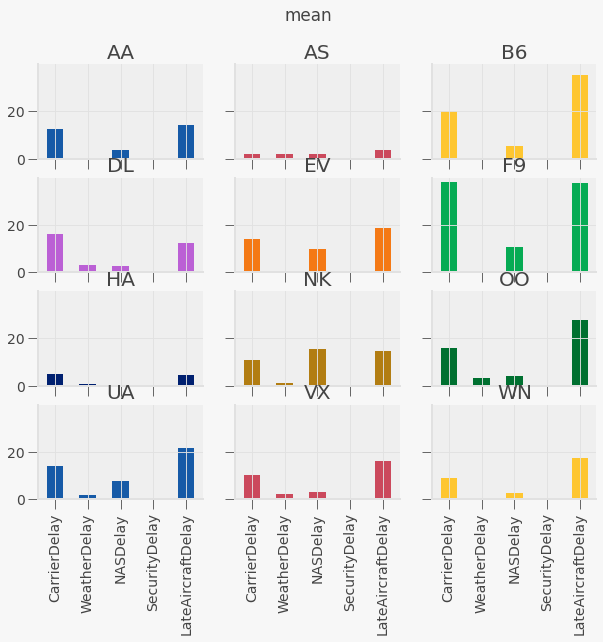

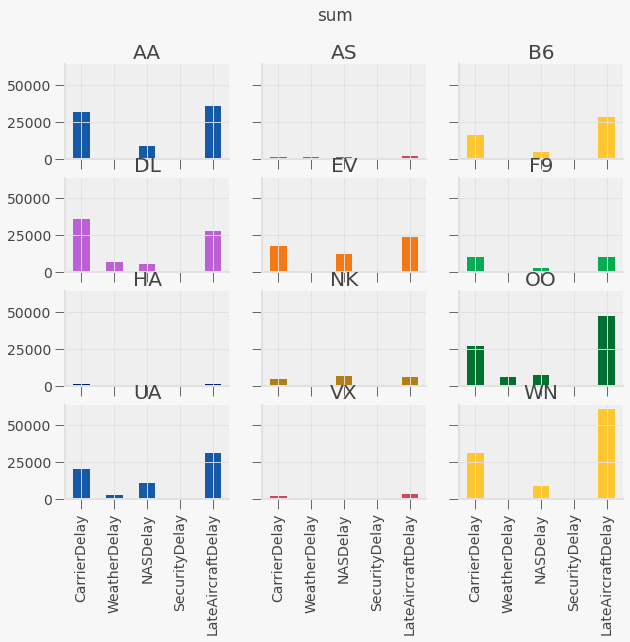

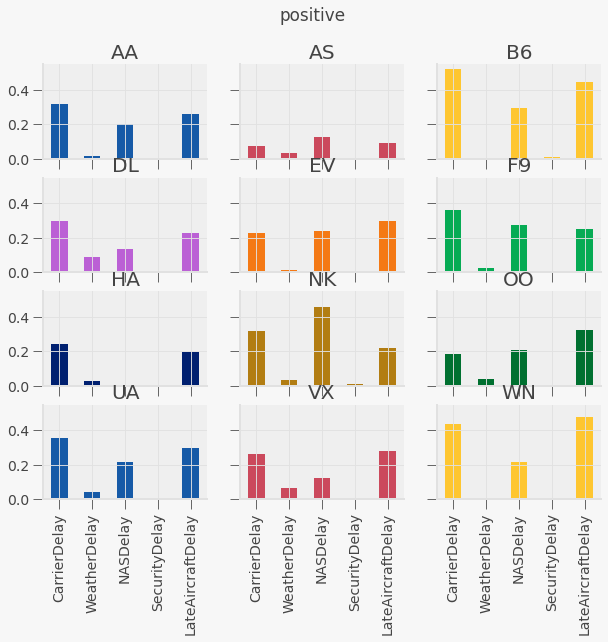

In [79]:
# only the 18th
delay_type_plot(air_dec, "12-18-16", "12-18-16")

The purpose of this exercise was to drive home the ability to *automate*
tasks.

We were able to write a pair of `functions` that allows us to easily
repeat the exact same analysis on different subsets of the data, or
different datasets entirely (e.g. we could do the same analysis on
November 2016 data, with two lines of code).

These principles can be applied in many settings.

Keep that in mind as we work through the rest of the materials.